In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog, shotchartdetail
from tqdm import tqdm

# 設定顯示所有欄位，方便檢查
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# --- Configuration ---
TARGET_PLAYER_NAME = "Stephen Curry"
SEASON_ID = "2023-24"
# ---------------------

# 取得球員 ID
nba_players = players.get_players()
target_player = [p for p in nba_players if p['full_name'] == TARGET_PLAYER_NAME][0]
player_id = target_player['id']

print(f"Target Player: {TARGET_PLAYER_NAME} (ID: {player_id})")
print(f"Target Season: {SEASON_ID}")

Target Player: Stephen Curry (ID: 201939)
Target Season: 2023-24


In [3]:
print("Fetching Game Logs...")

# 使用 playergamelog endpoint
gamelog = playergamelog.PlayerGameLog(player_id=player_id, season=SEASON_ID)
df_games = gamelog.get_data_frames()[0]

# 資料前處理：轉換日期格式、排序
df_games['GAME_DATE'] = pd.to_datetime(df_games['GAME_DATE'])
df_games = df_games.sort_values(by='GAME_DATE').reset_index(drop=True)

# 建立 "Next_Game_PTS" 作為 Label (監督式學習的答案)
# 我們把下一場的得分，平移到這一列，這樣模型就可以學 "這一場的輸入" -> "下一場的得分"
df_games['TARGET_PTS'] = df_games['PTS'].shift(-1)

# 移除最後一場 (因為它沒有 "下一場" 可以預測)
df_games_clean = df_games.dropna(subset=['TARGET_PTS'])

print(f"Total Games Fetched: {len(df_games)}")
print(f"Data for Training: {len(df_games_clean)} samples")
display(df_games_clean[['GAME_DATE', 'MATCHUP', 'PTS', 'TARGET_PTS']].head())

Fetching Game Logs...
Total Games Fetched: 74
Data for Training: 73 samples


,GAME_DATE,MATCHUP,PTS,TARGET_PTS
0,2023-10-24,GSW vs. PHX,27,41.0
1,2023-10-27,GSW @ SAC,41,24.0
2,2023-10-29,GSW @ HOU,24,42.0
3,2023-10-30,GSW @ NOP,42,21.0
4,2023-11-01,GSW vs. SAC,21,30.0


In [4]:
print("Fetching Shot Chart Data (This might take a few seconds)...")

# context_measure_simple='FGA' 代表抓取所有出手 (Field Goal Attempts)
shot_data = shotchartdetail.ShotChartDetail(
    team_id=0,
    player_id=player_id,
    context_measure_simple='FGA',
    season_nullable=SEASON_ID
)

df_shots = shot_data.get_data_frames()[0]

print(f"Total Shots Fetched: {len(df_shots)}")
display(df_shots[['GAME_ID', 'GAME_DATE', 'LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG']].head())

Fetching Shot Chart Data (This might take a few seconds)...
Total Shots Fetched: 1445


,GAME_ID,GAME_DATE,LOC_X,LOC_Y,SHOT_MADE_FLAG
0,0022300005,20231103,-188,153,0
1,0022300005,20231103,145,243,1
2,0022300005,20231103,50,272,1
3,0022300005,20231103,-45,0,0
4,0022300005,20231103,230,83,1


Visualizing Shot Chart for Game ID: 0022300062


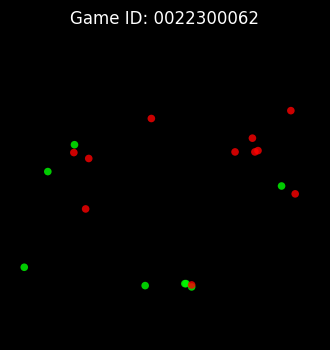

In [5]:
def generate_shot_chart_image(game_id, df_all_shots):
    """
    輸入某一場的 Game ID 和所有投籃資料，回傳一張圖
    """
    # 篩選出這場比賽的投籃
    game_shots = df_all_shots[df_all_shots['GAME_ID'] == game_id]
    
    if len(game_shots) == 0:
        return None

    # 設定畫布 (配合 CNN 輸入，正方形為佳)
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # 設定 NBA 球場座標範圍 (單位是 0.1 英呎)
    # X軸: -250 到 250 (籃框左右寬度)
    # Y軸: -50 到 420 (從底線到半場)
    ax.set_xlim(-250, 250)
    ax.set_ylim(-50, 420)
    
    # 移除座標軸 (CNN 不需要看刻度)
    ax.axis('off')
    
    # 畫背景 (黑色背景比較容易凸顯特徵)
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')

    # 分類進球與沒進
    made_shots = game_shots[game_shots['SHOT_MADE_FLAG'] == 1]
    missed_shots = game_shots[game_shots['SHOT_MADE_FLAG'] == 0]

    # 繪製散佈圖 (Scatter Plot)
    # 綠色=進球, 紅色=沒進, s=大小, alpha=透明度
    ax.scatter(made_shots['LOC_X'], made_shots['LOC_Y'], c='#00FF00', s=30, alpha=0.8, edgecolors='none')
    ax.scatter(missed_shots['LOC_X'], missed_shots['LOC_Y'], c='#FF0000', s=30, alpha=0.8, edgecolors='none')
    
    # 這邊只是顯示用，實際訓練時要存成 Tensor 或圖片檔
    plt.title(f"Game ID: {game_id}", color='white')
    plt.show()

# --- 測試畫出這一季的第一場比賽 ---
test_game_id = df_games_clean.iloc[0]['Game_ID']
print(f"Visualizing Shot Chart for Game ID: {test_game_id}")
generate_shot_chart_image(test_game_id, df_shots)

In [6]:
print("Performing Alignment Check...")

valid_samples = 0
missing_shots_games = []

# 檢查我們整理好的 Game Log 中的每一場比賽，是否都有對應的投籃資料
for index, row in df_games_clean.iterrows():
    gid = row['Game_ID']
    date = row['GAME_DATE']
    
    # 檢查 df_shots 裡面有沒有這個 Game ID
    shots_count = len(df_shots[df_shots['GAME_ID'] == gid])
    
    if shots_count > 0:
        valid_samples += 1
    else:
        missing_shots_games.append(gid)

print("-" * 30)
print(f"Total Numerical Samples: {len(df_games_clean)}")
print(f"Games with matching Shot Data: {valid_samples}")
print(f"Missing Data Games: {len(missing_shots_games)}")

if len(missing_shots_games) == 0:
    print("Perfect! All games have corresponding shot charts.")
else:
    print("Some games are missing shot data (could be DNP or data error).")

Performing Alignment Check...
------------------------------
Total Numerical Samples: 73
Games with matching Shot Data: 73
Missing Data Games: 0
Perfect! All games have corresponding shot charts.
